## Modelo ~ Wine Quality ~ Regressão logística

In [918]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

In [919]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_red = pd.read_csv('winequality-red.csv', sep=';')

### Definição das funções

In [920]:
#https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn

def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
       
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

### Renomeando as colunas e adaptando a variável resposta

In [921]:
df_white.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
df_red.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [922]:
df_white['quality'] = df_white['quality'].apply(lambda x: 1 if x > 6 else 0)
df_red['quality'] = df_red['quality'].apply(lambda x: 1 if x > 6 else 0)

### Matriz de correlação

#### Variáveis fortemente correlacionadas:
 - density
 - residual sugar

 - total sulfur dioxide
 - free sulfur dioxide

#### Mantidas:
 - residual sugar(mais estável)
 - total sulfur dioxide (provavelmente mais abrangente)

In [923]:
df_white.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1,-0.0428652,0.297878,0.106725,0.0946912,-0.0245422,0.112649,0.270031,-0.418341,-0.0132378,-0.106827,-0.0609896
volatile_acidity,-0.0428652,1,-0.15041,0.108627,-0.00493416,-0.0812129,0.117614,0.0101243,-0.0452036,-0.0169023,0.0339666,-0.0665162
citric_acid,0.297878,-0.15041,1,0.024621,0.0326595,0.0883141,0.0932187,0.0914252,-0.146193,0.0797663,-0.02917,-0.00111512
residual_sugar,0.106725,0.108627,0.024621,1,0.227844,0.346107,0.431252,0.780365,-0.180028,-0.00384398,-0.445257,-0.0894502
chlorides,0.0946912,-0.00493416,0.0326595,0.227844,1,0.167046,0.375244,0.508302,-0.0540065,0.0939307,-0.570806,-0.271779
free_sulfur_dioxide,-0.0245422,-0.0812129,0.0883141,0.346107,0.167046,1,0.618616,0.327822,-0.00627358,0.0522517,-0.272569,-0.0116167
total_sulfur_dioxide,0.112649,0.117614,0.0932187,0.431252,0.375244,0.618616,1,0.563824,-0.0118287,0.157825,-0.476619,-0.167977
density,0.270031,0.0101243,0.0914252,0.780365,0.508302,0.327822,0.563824,1,-0.110061,0.0950787,-0.821855,-0.30525
pH,-0.418341,-0.0452036,-0.146193,-0.180028,-0.0540065,-0.00627358,-0.0118287,-0.110061,1,0.140243,0.148857,0.0950223
sulphates,-0.0132378,-0.0169023,0.0797663,-0.00384398,0.0939307,0.0522517,0.157825,0.0950787,0.140243,1,-0.044868,0.0218354


In [924]:
y_train = df_white['quality']
y_test = df_red['quality']
df_white.drop(['quality', 'density', 'free_sulfur_dioxide'], axis=1, inplace=True)

## Seleção de variáveis

### Selecionando as variáveis mais significativas via StepWise

In [925]:
stepwisevars = stepwise_selection(df_white, y_train)

Add  alcohol                        with p-value 6.0214e-173
Add  volatile_acidity               with p-value 1.17822e-12
Add  residual_sugar                 with p-value 1.92263e-08
Add  pH                             with p-value 2.30251e-05
Add  sulphates                      with p-value 0.000484828


In [926]:
df_white = df_white[stepwisevars]
df_red = df_red[stepwisevars]

### Adicionando constante aos dataframes e ajustando o modelo

In [927]:
X_train = sm.add_constant(df_white)
X_test = sm.add_constant(df_red)

In [928]:
logit = sm.GLM(y_train, X_train, family=sm.families.Binomial())
result = logit.fit()

In [929]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 4898
Model:                            GLM   Df Residuals:                     4892
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2124.8
Date:                Mon, 03 Feb 2020   Deviance:                       4249.6
Time:                        00:18:04   Pearson chi2:                 4.67e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -14.9751      0.952  

### Métricas do modelo

In [930]:
X_test['score'] = result.predict(X_test)

### Curva ROC

ROCAUC SCORE: 86.0 %


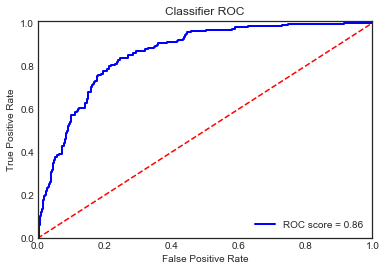

In [931]:
fpr, tpr, thresholds = roc_curve(y_test, X_test['score'])
roc_auc = auc(fpr, tpr)
print(f'ROCAUC SCORE: {round(roc_auc*100)} %')

plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Classifier ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC score = %0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()